In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import webcolors
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
plt.rcParams['axes.grid'] = False
from collections import defaultdict, deque

num2cat = {
    0: 'Backgroud',
    1: 'General trash',
    2: 'Paper',
    3: 'Paper pack',
    4: 'Metal',
    5: 'Glass',
    6: 'Plastic',
    7: 'Styrofoam',
    8: 'Plastic bag',
    9: 'Battery',
    10: 'Clothing'
}

cat2num = {
    'Backgroud':0,
    'General trash':1,
    'Paper': 2,
    'Paper pack': 3,
    'Metal': 4,
    'Glass': 5,
    'Plastic': 6,
    'Styrofoam': 7,
    'Plastic bag': 8,
    'Battery': 9,
    'Clothing': 10
}

In [2]:
def get_area(mask):
    visited = np.zeros(mask.shape,dtype=int)
    h,w = 256, 256

    indices_by_class = defaultdict(list)
    dirs = [[-1,0],[0,-1],[0,1],[1,0]]
    #dirs = [[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]]

    # bfs
    for i in range(h):
        for j in range(w):
            if visited[i][j]==0:
                target_class = mask[i][j]

                # bfs
                q = deque([[i,j]])
                visited[i][j] = 1
                temp = [[i,j]]

                while q:
                    p = q.popleft()

                    for dx, dy in dirs:
                        x = p[0] + dx
                        y = p[1] + dy

                        if 0<=x<h and 0<=y<w and visited[x][y]==0 and mask[x][y]==target_class:
                            q.append([x,y])
                            visited[x][y] = 1
                            temp.append([x,y])
                
                indices_by_class[num2cat[target_class]].append(temp)

        # 크기 내림차순 정렬인데 할 필요 없음
        for k in indices_by_class.keys():
            indices_by_class[k].sort(key=lambda x:len(x), reverse=True)
                
    return indices_by_class


def get_adjclass(cur_class,area,mask):
    #dirs = [[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]] # 방법 1: 거리 1만큼 탐색
    #'''
    dirs = [ # 방법 2: 거리 2만큼 탐색
        [-2,-2],[-2,-1],[-2,0],[-2,1],[-2,2],
        [-1,-2],[-1,-1],[-1,0],[-1,1],[-1,2],
        [0,-2],[0,-1],[0,1],[0,2],
        [1,-2],[1,-1],[1,0],[1,1],[1,2],
        [2,-2],[2,-1],[2,0],[2,1],[2,2],
    ]
    #'''
    result = defaultdict(int)
    for cor in area:
        x, y = cor
        for dx, dy in dirs:
            x = cor[0] + dx
            y = cor[1] + dy

            # 현재 구역에 포함 안된 점들로 정보 수집
            if 0<=x<256 and 0<=y<256 and not [x,y] in area:
                result[mask[x][y]] += 1

    result = [[k,v] for k,v in result.items()]
    result.sort(key=lambda x:x[1], reverse=True)

    k, v = result[0]

    return k, v

# y축 = area//10
![nn](size.png)

 13%|█▎        | 108/819 [00:57<06:16,  1.89it/s]


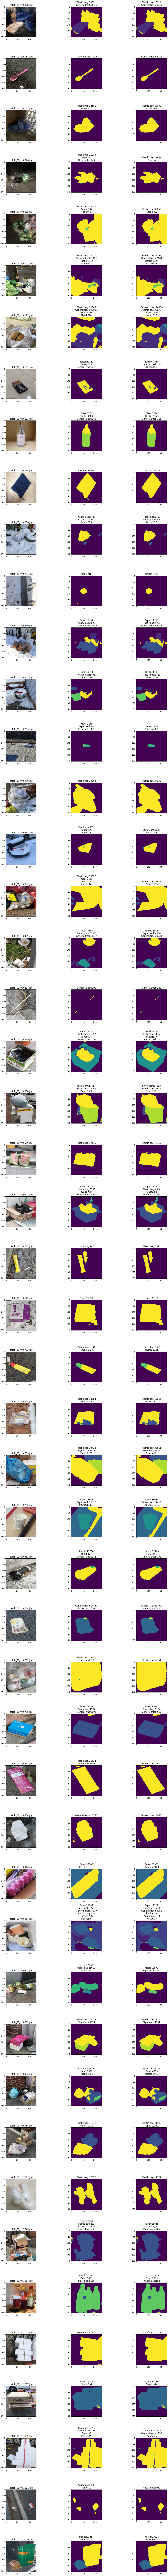

In [7]:
# 지정할 거 1: csv 파일
#csv_dir = '/opt/ml/input/level2_semanticsegmentation_cv-level2-cv-01/mmsegmentation/work_dirs/upernet_beit-base_640x640_160k_ade20k_ms/submission_best_mIoU_epoch_80.csv'
#csv_dir = '/opt/ml/input/level2_semanticsegmentation_cv-level2-cv-01/mmsegmentation/work_dirs/upernet_beit-base_640x640_160k_ade20k_ms/submission_latest.csv'
#csv_dir = '/opt/ml/input/level2_semanticsegmentation_cv-level2-cv-01/mmsegmentation/work_dirs/upernet_beit-base_640x640_160k_ade20k_ms/submission_best_mIoU_epoch_80_converted_16.csv'
csv_dir = '/opt/ml/input/sota.csv'

# 지정할 거 2: 무조건 삭제할 넓이(가장 많이 인접한 클래스로 변환)
thr1 = 30

# 지정할 거 3: exclude에 포함된 클래스의 경우 제외하고 thr2 이하인 경우 모두 삭제(가장 많이 인접한 클래스로 변환)
thr2 = 150
exclude = set([
    'General trash',
    'Plastic bag',
    'Plastic',
])

# 지정할 거 4: include에 포함된 클래스의 경우 thr3 이하인 경우 모두 삭제(가장 많이 인접한 클래스로 변환)
thr3 = 200
include = set([
    "Metal",
    "Styrofoam",
    "Backgroud",
    "Battery",
])
'''
클래스별 최소
'''
num_examples = 50 # 확인할 이미지 개수
viz = True # True: num_examples만큼 시각과 / False: 시각화 안고 csv 저장만함

###########################################################################################################################################

# 1차 제거
df = pd.read_csv(csv_dir)
data_dir = '/opt/ml/input/data'


if viz:
    fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(16, 4*num_examples), constrained_layout=True)
idx = 0
for i in tqdm(range(len(df))):
    image_name, PredictionString = df.iloc[i]
    mask = np.array(list(map(int,PredictionString.split(' '))))
    class_type = dict(pd.Series(mask).value_counts())
    mask = mask.reshape(256,256)

    #prac = np.zeros((256,256))
    prac = mask.copy()

    
    # 영역 크기 고려: 영역 지우기 
    total_area = 0 # 모들 픽셀이 영역에 포함됐는지 확인
    small = False # thr 보다 작은 area가 존재하는지 여부
    for class_name,area_list in get_area(mask).items():
        for area in area_list:
            #print('크기',len(area))
            total_area += len(area)
            for cor in area:
                prac[cor[0]][cor[1]] = cat2num[class_name]
            
            if len(area)< thr1 or (len(area)< thr2 and not class_name in exclude) or (len(area)< thr3 and class_name in include):
            #if len(area)< thr1 or (len(area)< thr2 and not class_name in exclude):
            #if len(area)< thr1:
                small = True if viz else False
                #tar_k, v = get_adjclass(cat2num[class_name], area, mask)
                tar_k, v = get_adjclass(cat2num[class_name], area, prac)
                for x,y in area:
                    prac[x][y] = tar_k

    if small:
        ax[idx][0].imshow(plt.imread(os.path.join(data_dir,image_name)))
        ax[idx][0].set_title(image_name)

        ax[idx][1].imshow(mask)
        title = '\n'.join([f"{num2cat[k]}:{v}" for k,v in class_type.items() if k!=0])
        ax[idx][1].set_title(title)

        class_type = dict(pd.Series(prac.reshape(65536)).value_counts())
        class_type = {num2cat[k]:v for k,v in class_type.items()  if k!=0}

        ax[idx][2].imshow(prac)
        title = '\n'.join([f"{k}:{v}" for k,v in class_type.items()])
        ax[idx][2].set_title(title)


        idx += 1
    

    df.iloc[i]['PredictionString'] = ' '.join(map(str,list(prac.reshape(256*256).astype('uint8'))))

    if viz and idx==num_examples:
        break

if viz:
    fig.tight_layout()

if not viz:
    fpath = '/'.join(csv_dir.split('/')[:-1])
    file_name = csv_dir.split('/')[-1].split('.')[0] + f'_converted_{thr1}_{thr2}.csv'
    df = df[['image_id', 'PredictionString']]
    save_dir = fpath +'/' + file_name

    #df.to_csv(save_dir, index=False)
